In [1]:
sys.path.append("..")
import os
import utils
import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Read data from Norway

In [2]:
data_daily = pd.read_csv("../data/fhi_data_daily.csv")
# data_daily = data_daily[data_daily.year.astype(int) < 2021].reset_index() uncomment if only plotting data fro 2021 
data_daily = data_daily[['date', 'I_new', 'I_cumulative', 'D_new', 'D_cumulative']]
data_daily.date = data_daily['date'].apply(lambda x: 
                                        x.split("/")[1].zfill(2) + "/"
                                        + x.split("/")[0].zfill(2) + "/"
                                        + x.split("/")[2].zfill(2))
data_daily.head()

,date,I_new,I_cumulative,D_new,D_cumulative
0,21/02/2020,1.0,1.0,0.0,0.0
1,22/02/2020,0.0,1.0,0.0,0.0
2,23/02/2020,0.0,1.0,0.0,0.0
3,24/02/2020,0.0,1.0,0.0,0.0
4,25/02/2020,0.0,1.0,0.0,0.0


### Read output from simulations

In [3]:
dir_path = "../"
relative_path = "results/10_simulations_susceptible_based_2021_05_29_11_17_29"
path = dir_path + relative_path
mdp_paths_path   =   f"{path}/mdp_paths.pkl"
mdp_reffs_path   =   f"{path}/mdp_reffs.pkl"
start_date_population_age_labels_path = f"{path}/start_date_population_age_labels.pkl"
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
start_date, population, age_labels = utils.read_pickle(start_date_population_age_labels_path)
mdp_paths = utils.read_pickle(mdp_paths_path)
R_effs = utils.read_pickle(mdp_reffs_path)
mdp_path = mdp_paths[-1]
R_eff = R_effs[-1]

# Retrive data
dates = []
num_simulations = len(mdp_paths)
num_simulation_weeks = len(mdp_paths[0])

vaccinated_per_age_group =  [[0] * num_simulation_weeks] * num_simulations
vaccinated_per_region =  [[0] * num_simulation_weeks] * num_simulations
final_deaths = np.zeros((num_simulations, num_simulation_weeks))
final_infected = np.zeros((num_simulations, num_simulation_weeks))

for i in range(num_simulations):
    for j in range(num_simulation_weeks):
        if i == 0:
            dates.append(mdp_paths[i][j].date)
        final_deaths[i][j] = np.sum(mdp_paths[i][j].new_deaths)
        final_infected[i][j] = np.sum(mdp_paths[i][j].new_infected)
        if j < num_simulation_weeks -1:
            vaccinated_per_age_group[i][j] = np.sum(mdp_paths[i][j].V, axis=0, dtype=int) - np.sum(mdp_paths[i-1][j-1].V, axis=0, dtype=int) 
            vaccinated_per_region[i][j] = np.sum(mdp_paths[i][j].V, axis=1, dtype=int) - np.sum(mdp_paths[i-1][j-1].V, axis=1, dtype=int) 
    

### Vaccination

In [5]:
vaccinated_per_region[6][60]

array([7551,  152, 1543,  404,  863,   15,   13,   -1,  205,  203,  200,
        140,  297,   83,  152,   55,    9,   77,  -29,    8,  120,  462,
         -1,   88,  253,  323,  747,   51,   22,   84,  103,   30,  121,
         80,   80,  115,  131,  119,   79,   68,   85,   72,   36,   99,
        -15,   92,   18,  141,   -8,  144,  554,  284,   32,   49,   14,
        -13,   10,   13,   58,   21,  154,    7,   18,  -19,   19,   -7,
        275,  -20,   20,   17,   66,   44,  -30,   46,  115,   22,   45,
         17,  -11,   37,   23,   39,  119,  139,  151,   13,   73,  175,
         64,   12,   21,  349,  512,  632,  895, 1093,  303,  312,   42,
         38,   -2,  501,  -15,   52,   69,  -10,  179,  668,  183,  156,
        186, 1380, 1001,  181,  206,  123,  455,  947,  265,   53,  406,
        256,  264,  126,   42,    5,   65,   39,   56,   -1,   75,   78,
         42,  -11,  106,  220,  255,  -16,    8,    6,   24,   33,  205,
        344,  258,  332,  381,   86,  231,   62,   

In [28]:
vaccinated_per_age_group[6][60]

array([11542, 20548,  7970,  6996,  5776,  3320,  1270])

### Find cumulative cases of deaths and infected from model

In [6]:
percentile_limit=90

deaths_cumulative = final_deaths.cumsum(axis=1)
deaths_mean = final_deaths.mean(axis=0)
deaths_mean_cumulative = deaths_cumulative.mean(axis=0)
u_percentile_deaths = np.percentile(final_deaths, percentile_limit, axis=0)
l_percentile_deaths = np.percentile(final_deaths, 100-percentile_limit, axis=0)
u_percentile_deaths_cum = np.percentile(deaths_cumulative, percentile_limit, axis=0)
l_percentile_deaths_cum = np.percentile(deaths_cumulative, 100-percentile_limit, axis=0)

infected_cumulative = final_infected.cumsum(axis=1)
infected_mean = final_infected.mean(axis=0)
infected_mean_cumulative = infected_cumulative.mean(axis=0)
u_percentile_infected = np.percentile(final_infected, percentile_limit, axis=0)
l_percentile_infected = np.percentile(final_infected, 100-percentile_limit, axis=0)
u_percentile_infected_cum = np.percentile(infected_cumulative, percentile_limit, axis=0)
l_percentile_infected_cum = np.percentile(infected_cumulative, 100-percentile_limit, axis=0)

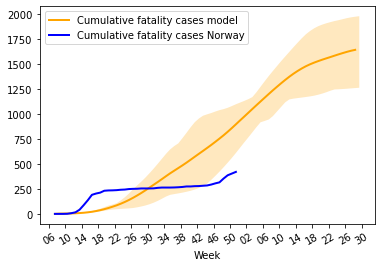

In [27]:
restrict_to_real_data_length = False
max_weeks_real_data = 45

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')

if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], deaths_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative fatality cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.D_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color='blue')
    #ax.fill_between(dates, u_percentile_deaths, l_percentile_deaths, facecolor='blue', alpha=0.25)
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_deaths_cum[:max_weeks_real_data], l_percentile_deaths_cum[:max_weeks_real_data], facecolor='orange', alpha=0.25)
else:
    ax.plot(dates[:-1], deaths_mean_cumulative[:-1], lw=2, label='Cumulative fatality cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.D_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color='blue')
    #ax.fill_between(dates, u_percentile_deaths, l_percentile_deaths, facecolor='blue', alpha=0.25)
    ax.fill_between(dates, u_percentile_deaths_cum, l_percentile_deaths_cum, facecolor='orange', alpha=0.25)
#ax.set_title(r'Cumulative and new deaths per week')
ax.legend(loc='upper left')

# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%U')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=28)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation = 30)
ax.set_xlabel("Week")

fig.savefig("../plots/computational_study/deaths_comparison.png", bbox_inches='tight', dpi=150)

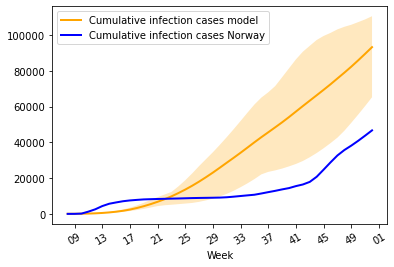

In [25]:
restrict_to_real_data_length = True
max_weeks_real_data = 45

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.I_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color='blue')
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_infected_cum[:max_weeks_real_data], l_percentile_infected_cum[:max_weeks_real_data], facecolor='orange', alpha=0.25)
else:
    ax.plot(dates[:-1], infected_mean_cumulative[:-1], lw=2, label='Cumulative infection cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], data_daily.I_cumulative.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color='blue')
    #ax.fill_between(dates, u_percentile_deaths, l_percentile_deaths, facecolor='blue', alpha=0.25)
    ax.fill_between(dates, u_percentile_infected_cum, l_percentile_infected_cum, facecolor='orange', alpha=0.25)

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')

# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%U')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=28)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation = 30) 
ax.set_xlabel("Week")

fig.savefig("../plots/computational_study/infected_comparison.png", bbox_inches='tight', dpi=150)